# Hierarchical SHAP

This notebook contains code and examples for a hierarchical implementation of Shapley coefficients evaluation for images, with a fixed size of features per layer.



In [ ]:
%matplotlib inline

#IMPORTS
from scipy.special import comb
from itertools import permutations
from functools import reduce
import time
import numpy as np
import torch 
import scipy as sp
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

#IMPORT UTILS
!wget https://raw.githubusercontent.com/JacopoTeneggi/Interpretability/master/Utils/utils.py -P local_modules -nc
import local_modules.utils as Utils

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/utils.py’ already there; not retrieving.



## Load the model

This pre-trained model detects the presence of a cross in the image. If the cross is detected, the image is labeled with a ```1```, with a ```0``` otherwhise.

In [ ]:
#LOAD PRE-TRAINED-NETWORK
model = Utils.Net()
model.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 
# model.eval() deactivates the dropout layer in the network
model.eval()

MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])
transf = transforms.Compose([ToTensor(), Normalize(mean=MEAN, std=STD)])

# LOAD TRAIN DATA
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data2/data.zip", 'r')
train_data_dir = "train_data_dir"
data.extractall(train_data_dir)
data.close()
train_batch_size = 64
train_data = ImageFolder(root = os.path.join(train_data_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = train_batch_size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
X, Y = next(train_loader)
# DEFINE MASK BACKGROUND WITH AVERAGE OF TRAINING SET
background = torch.mean(X, dim = 0)
background.detach()

# LOAD EXAMPLE IMAGES
ImF = ImageFolder(root = "/content/drive/My Drive/Interpretability/img4saliencymap/data2", transform = transf)
example_batch_size = 2
exloader = DataLoader(ImF, batch_size = example_batch_size, shuffle = False, num_workers = 0)
exIter = iter(exloader)
images, labels = next(exIter)

# LABEL = 0
image0 = images[0]
label0 = labels[0]
input0 = image0.view(-1, 3, 100, 120)
output0 = model(input0)
print(output0)

# LABEL = 1
image1 = images[1]
label1 = labels[1]
input1 = image1.view(-1, 3, 100, 120)
output1 = model(input1)
print(output1)

tensor([[ 11.1314, -13.0076]], grad_fn=<AddmmBackward>)
tensor([[-79.0918,  88.0700]], grad_fn=<AddmmBackward>)


## Hierarchical SHAP implementation

This implementation relies on two classes:

1. ```HierarchicalSHAPExplainer```

2. ```HierarchicalSHAPNode```

### HierarchicalSHAPNode

It is the class that takes care of the actual evaluation of Shapley coefficients. It explores relevant features recursively so that we only get the deepest, most relevant features as an output. We do not save any intermediate nodes to save memory and reduce complexity.

### HierarchicalSHAPExplainer

It is a wrapper class that initialize the environment for the nodes. The ```explain()``` method simply calls the evaluation on the root node (i.e. the entire imagine).

In [ ]:
class HierarchicalSHAPNode:
  """
  Represents the single feature
  """

  def __init__(self, explainer, depth, M, features, masks, path = None, score = None):
    self.explainer = explainer
    self.depth = depth
    self.M = M
    self.features = features
    self.masks = masks
    self.path = path
    self.score = score

  def computeShap(self, feature, predictions):
    feature_index = np.where(feature == 1)
    subset_indices = np.where(self.masks[:, feature_index[0][0]] == 0)
    subset = self.masks[subset_indices]
    added_subset = [np.add(sub, feature) for sub in subset] 
    deltas = np.array(list(zip(added_subset, subset)))
    diffs = [1/comb(self.M - 1, np.sum(b)) * (predictions[self.mask2str(a)] - predictions[self.mask2str(b)]) for a, b in deltas]
    phi = np.sum(diffs) / self.M
    return phi.detach().numpy()

  def mask2path(self, mask):
    if self.path is None:
      return [mask]
    else:
      return np.concatenate((self.path, mask))
  
  def mask2str(self, mask):
    return reduce(lambda a, b: str(a) + str(b), mask.astype(int)) 

  def str2mask(self, string):
    L = len(string) 
    mask = np.empty((L,))
    for i in range(L):
      mask[i] = int(string[i])
    return mask
  
  def pathMaskCoordinates(self, path, startRow = 0, endRow = 100, startColumn = 0, endColumn = 120):
    if path is not None:
      for layer in path:
        w = endColumn - startColumn
        h = endRow - startRow
        feature_index = np.where(layer == 1)[0]
        if feature_index == 0:
          endRow = startRow + h / 2
          endColumn = startColumn + w / 2
        elif feature_index == 1:
          endRow = startRow + h / 2
          startColumn += w / 2
        elif feature_index == 2:
          startRow += h / 2
          endColumn = startColumn + w / 2
        elif feature_index == 3:
          startRow += h / 2
          startColumn += w / 2
    return int(startRow), int(endRow), int(startColumn), int(endColumn)
  
  def maskInput(self, mask, rootInput, startRow, endRow, startColumn, endColumn, background):
    w = endColumn - startColumn
    h = endRow - startRow
    if (type(rootInput) == np.ndarray):
      maskedInput = rootInput.copy()
    else:
      maskedInput = rootInput.clone();
    maskIndices = np.where(mask == 0)[0]
    for index in maskIndices:
      maskStartRow = startRow
      maskEndRow = endRow
      maskStartColumn = startColumn
      maskEndColumn = endColumn
      # First quadrant
      if index == 0:
        maskEndRow = startRow + h / 2
        maskEndColumn = startColumn + w / 2
      # Second quadrant
      elif index == 1:
        maskEndRow = startRow + h / 2
        maskStartColumn += w / 2
      # Third quadrant
      elif index == 2:
        maskStartRow += h / 2
        maskEndColumn = startColumn + w / 2
      # Fourth quadrant
      elif index == 3:
        maskStartRow += h / 2
        maskStartColumn += w / 2
      maskStartRow = int(maskStartRow)
      maskEndRow = int(maskEndRow)
      maskStartColumn = int(maskStartColumn)
      maskEndColumn = int(maskEndColumn)
      maskedInput[:, maskStartRow:maskEndRow, maskStartColumn:maskEndColumn] = background[:, maskStartRow:maskEndRow, maskStartColumn:maskEndColumn]
    if (type(maskedInput) is not np.ndarray):
      maskedInput = maskedInput.view(-1, 3, 100, 120)
    return maskedInput

  def rootPathInput(self, path, input, background, w = 120, h = 100):
    startRow, endRow, startColumn, endColumn = self.pathMaskCoordinates(path, 0, h, 0, w)
    if (type(background) == np.ndarray):
      rootInput = background.copy()
    else:
      rootInput = background.clone()
    rootInput[:, startRow:endRow+1, startColumn:endColumn+1] = input[:, startRow:endRow+1, startColumn:endColumn+1]
    return rootInput, startRow, endRow, startColumn, endColumn
  
  def nodeScores(self, input, background, label, threshold, minW, minH):
    # 
    rootInput, startRow, endRow, startColumn, endColumn = self.rootPathInput(self.path, input, background)
    rootw = endColumn - startColumn
    rooth = endRow - startRow
    # Stop when it reaches the deepest layer and return current node
    if (rootw < 2*minW) or (rooth < 2*minH):
      return self
    # If not, go down another level and compute shap coefficients for features
    predictions = {self.mask2str(mask): self.explainer.model(self.maskInput(mask, rootInput, startRow, endRow, startColumn, endColumn, background))[:, label] for mask in self.masks}
    phis = {self.mask2str(feature): self.computeShap(feature, predictions) for feature in self.features}

    # Update number of computed features
    self.explainer.computed += self.M

    # Convert SHAP dictionary to lists -> TODO: evaluate wether SHAP dictionary is necessary
    values = np.fromiter(phis.values(), dtype=float)
    keys = list(phis.keys())

    # Identify relevant features
    if threshold is not None:
      relevantIndices = np.where(values > threshold)[0]
    else:
      relevantIndices = np.arange(self.M)

    # Update number of rejected features
    self.explainer.rejected += self.M - len(relevantIndices)

    # Initialize children and recursively compute SHAP values
    children = []
    for relevantIndex in relevantIndices:
      childPath = np.array([self.str2mask(keys[relevantIndex])])
      if self.path is not None:
        childPath = np.concatenate((self.path, childPath))
      child = HierarchicalSHAPNode(self.explainer, self.depth + 1, self.M, self.features, self.masks, path = childPath, score = values[relevantIndex])
      children.append(child.nodeScores(input, background, label, threshold, minW, minH))
    return children

class HierarchicalSHAPExplainer:

  def __init__(self, model, background, M):
    self.model = model
    self.computed = None
    self.rejected = None
    self.M = M
    self.MEAN = np.array([0.5, 0.5, 0.5])
    self.STD = np.array([0.5, 0.5, 0.5])
    self.input = input
    self.background = background
    self.masks = self.generateMasks() 
    self.features = np.identity(self.M, dtype=np.bool).reshape((self.M, self.M))

  def generateMasks(self):
    masks = np.ones((1,self.M), dtype=np.bool) # initialize masks array with all features on -> no need to compute permutations fro |S| = M
    for i in range(self.M):
      s = np.zeros(self.M, dtype=np.bool)
      s[0:i] = 1
      p = permutations(s)
      a = np.array(list(set(p)))
      masks = np.concatenate((masks, a))
    return masks

  def flatten(self, l):
    for el in l:
      if isinstance(el, list) and not isinstance(el, (str, bytes)):
        yield from self.flatten(el)
      else:
        yield el

  def addNodeMask(self, node, map):
    startRow, endRow, startColumn, endColumn = node.pathMaskCoordinates(node.path)
    nodeArea = (endRow + 1 - startRow) * (endColumn + 1 - startColumn)
    map[startRow:endRow+1, startColumn:endColumn+1] = node.score / nodeArea

  def explain(self, input, background, label = None, threshold = 0, minW = 2, minH = 2):
    self.computed = 0
    self.rejected = 0
    mainNode = HierarchicalSHAPNode(self, 0, 4, self.features, self.masks, score = 1)
    nodes = mainNode.nodeScores(input, background, label, threshold, minW, minH)
    flatnodes = list(self.flatten(nodes))
    saliency_map = np.zeros((100, 120))
    for node in flatnodes:
      self.addNodeMask(node, saliency_map)
    return saliency_map, flatnodes

# Initialize explainer
explainer = HierarchicalSHAPExplainer(model, background, 4)

## Explaining label ```1``` for image labeled ```1```

We are testing with the lowest threshold possible (```0```) and the smallest input allowed (```1x1```) to evaluate performance in a worst-case scenario.


STARTED EXPLAINING IMAGE 1 @ 1597510684.7189612 s


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Computed 1288 features out of 12000 pixels (10.73 %) in 12927.803 ms -> 10.037 ms per feature
Rejected 522 features (40.53 %) @ threshold = 0.0 , minimal feature size = (1,1)


Text(0.5, 1.0, 'Explanation')

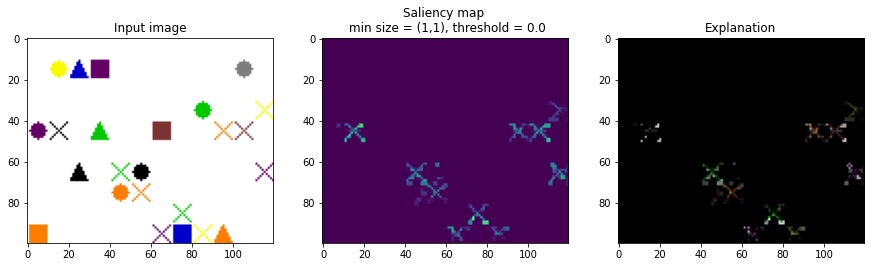

In [ ]:
# EXPLAIN IMAGE 1 (with correct label)
t0 = time.time()
print("STARTED EXPLAINING IMAGE 1 @", t0, "s")
threshold = 0
minW = 1
minH = 1
saliency_map, flatnodes = explainer.explain(image1, background, label = 1, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
computed = explainer.computed
rejected = explainer.rejected
print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))

fix, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 10))
im = Utils.input2image(image1, MEAN, STD)
ax1.imshow(im)
ax1.set_title("Input image")
ax2.imshow(saliency_map)
ax2.set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))
for i in np.arange(3):
  im[:, :, i] = saliency_map * im[:, :, i]
ax3.imshow(im)
ax3.set_title('Explanation')

## Explaining label ```0``` for image labeled ```1```

STARTED EXPLAINING IMAGE 1 @ 1597510706.2064168 s
Computed 4 features out of 12000 pixels (0.03 %) in 50.128 ms -> 12.532 ms per feature
Rejected 4 features (100.00 %) @ threshold = 0.0 , minimal feature size = (1,1)


Text(0.5, 1.0, 'Saliency map \n min size = (1,1), threshold = 0.0')

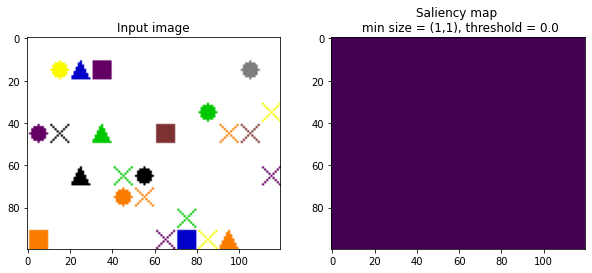

In [ ]:
# EXPLAIN LABEL 0 FOR IMAGE 1
t0 = time.time()
print("STARTED EXPLAINING IMAGE 1 @", t0, "s")
threshold = 0
minW = 1
minH = 1
saliency_map, flatnodes = explainer.explain(image1, background, label = 0, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
computed = explainer.computed
rejected = explainer.rejected
print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
im = Utils.input2image(image1, MEAN, STD)
ax1.imshow(im)
ax1.set_title("Input image")
ax2.imshow(saliency_map)
ax2.set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))

## Explaining label ```0``` for image labeled ```0```

We are testing with the lowest threshold possible (```0```) and the smallest input allowed (```1x1```) to evaluate performance in a worst-case scenario. 

STARTED EXPLAINING IMAGE @ 1597510713.0216925 s
Computed 4 features out of 12000 pixels (0.03 %) in 13155.248 ms -> 3288.812 ms per feature
Rejected 4 features (100.00 %) @ threshold = 0.0 , minimal feature size = (1,1)


Text(0.5, 1.0, 'Saliency map \n min size = (1,1), threshold = 0.0')

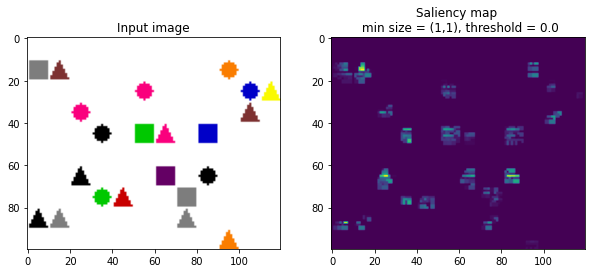

In [ ]:
# EXPLAIN IMAGE 0
t0 = time.time()
print("STARTED EXPLAINING IMAGE @", t0, "s")
threshold = 0
minW = 1
minH = 1
saliency_map, flatnodes = explainer.explain(image0, background, label = 0, threshold = threshold, minW = minW, minH = minH)
tf = time.time()
print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))

fix, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
im = Utils.input2image(image0, MEAN, STD)
ax1.imshow(im)
ax1.set_title("Input image")
ax2.imshow(saliency_map)
ax2.set_title('Saliency map \n min size = (%d,%d), threshold = %.1f' % (minW, minH, threshold))

## Trying out different minimal feature sizes and thresholds

These examples explain label ```1``` for the positive (labeled as ```1```) image.


STARTED EXPLAINING IMAGE @ 1597510738.4133413 s
Computed 20 features out of 12000 pixels (0.17 %) in 197.861 ms -> 9.893 ms per feature
Rejected 9 features (45.00 %) @ threshold = 0.0 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1597510738.616933 s
Computed 20 features out of 12000 pixels (0.17 %) in 198.310 ms -> 9.915 ms per feature
Rejected 10 features (50.00 %) @ threshold = 0.5 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1597510738.8206425 s
Computed 20 features out of 12000 pixels (0.17 %) in 209.541 ms -> 10.477 ms per feature
Rejected 10 features (50.00 %) @ threshold = 1.5 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1597510739.0351586 s
Computed 20 features out of 12000 pixels (0.17 %) in 201.094 ms -> 10.055 ms per feature
Rejected 10 features (50.00 %) @ threshold = 2.0 , minimal feature size = (20,20)

STARTED EXPLAINING IMAGE @ 1597510739.242822 s
Computed 20 features out of 12000 pixels (0.17 %) in 199.554 ms -> 9.978 ms 

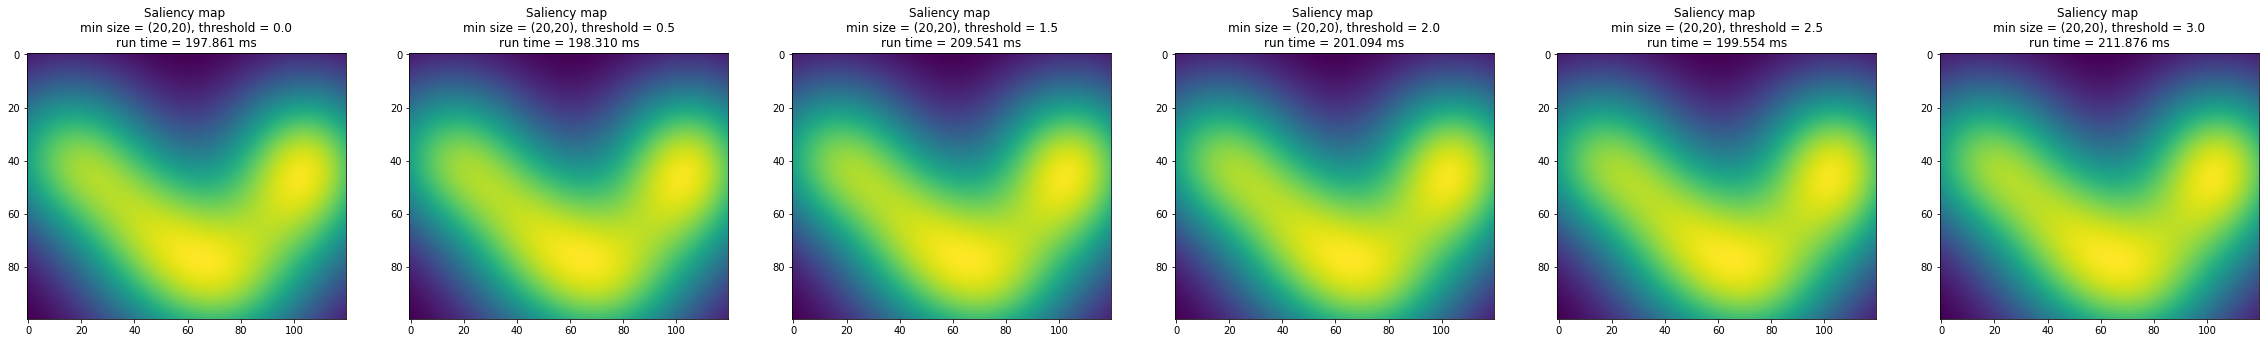

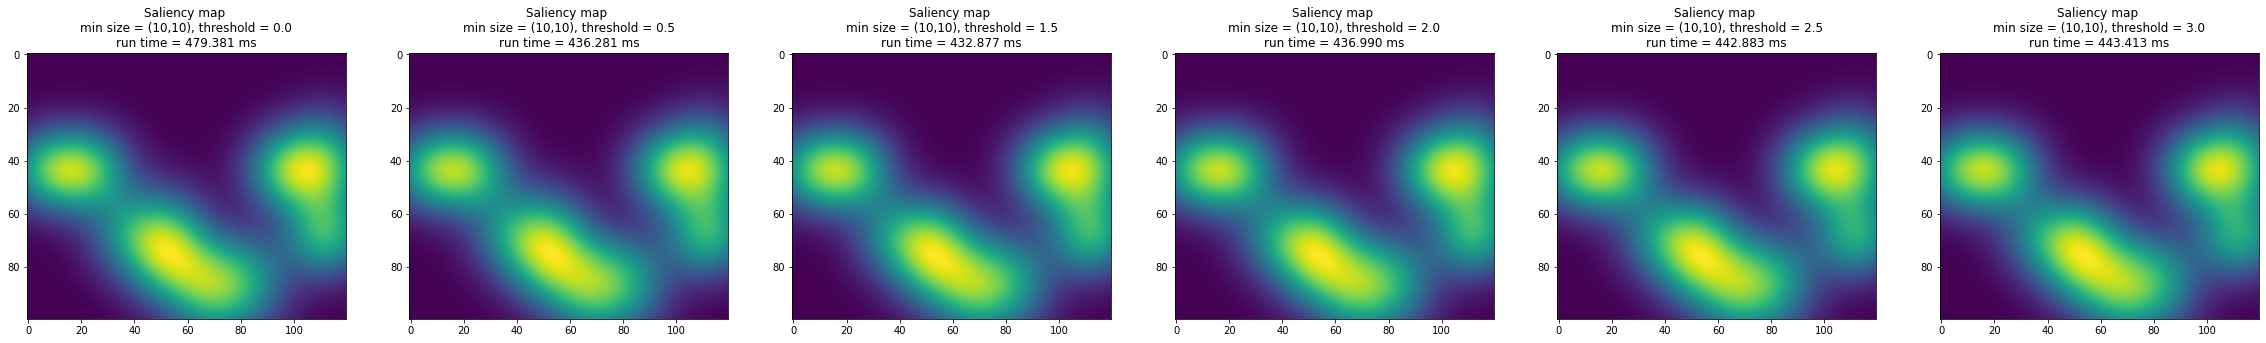

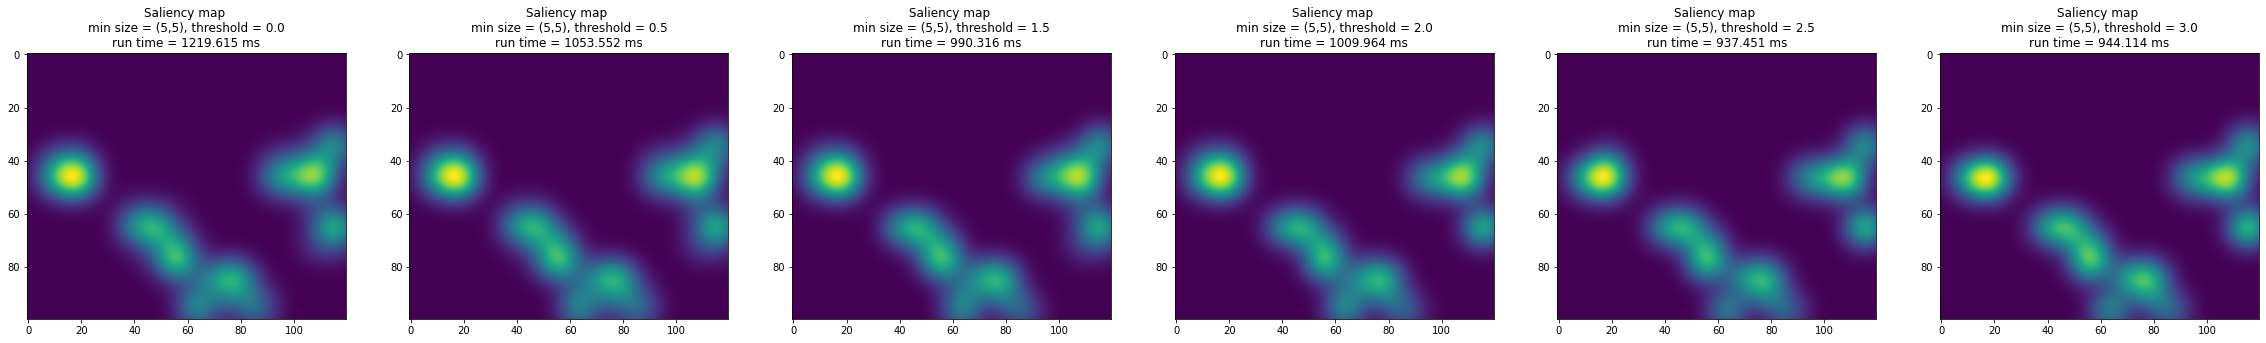

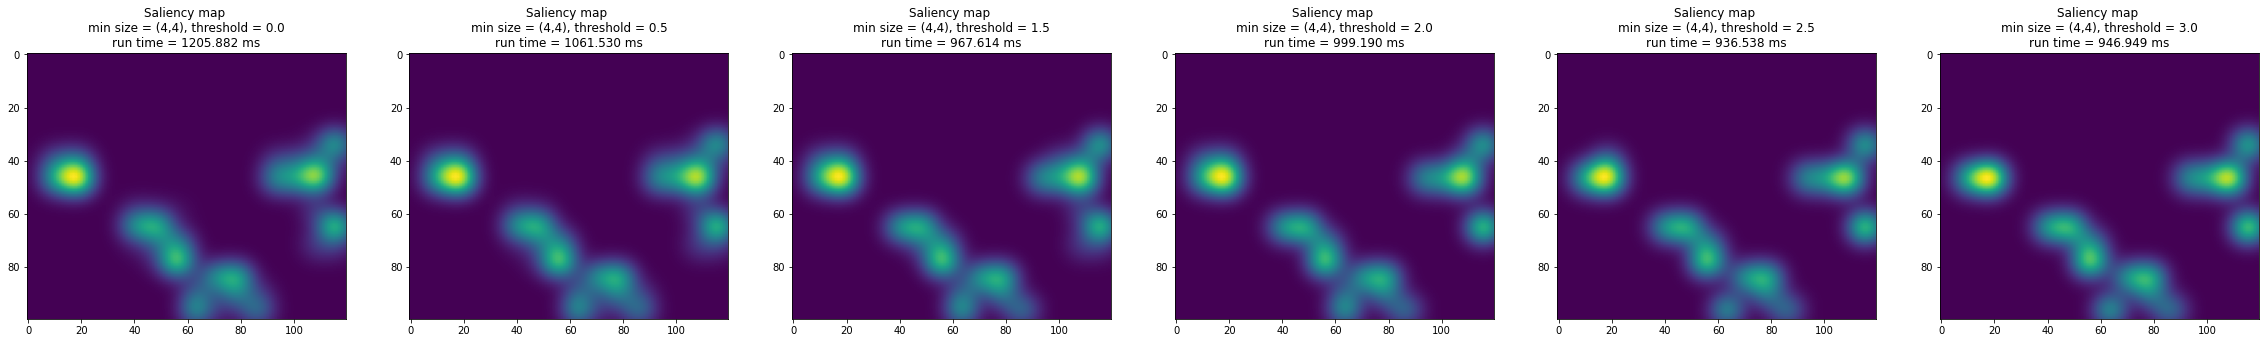

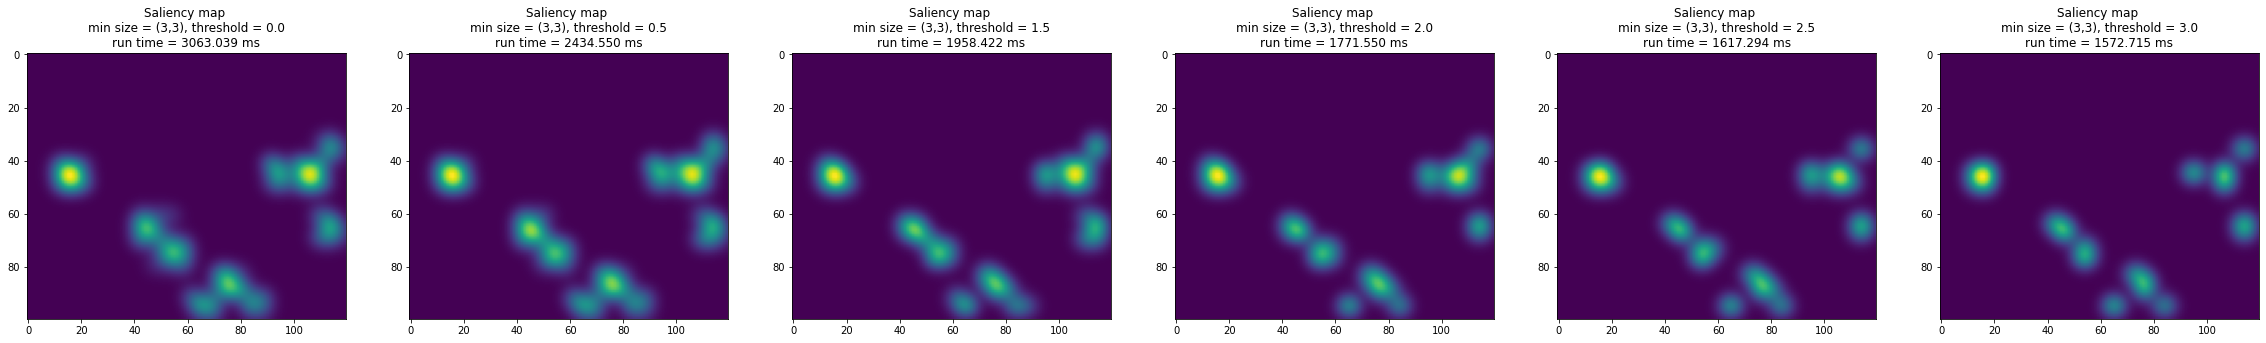

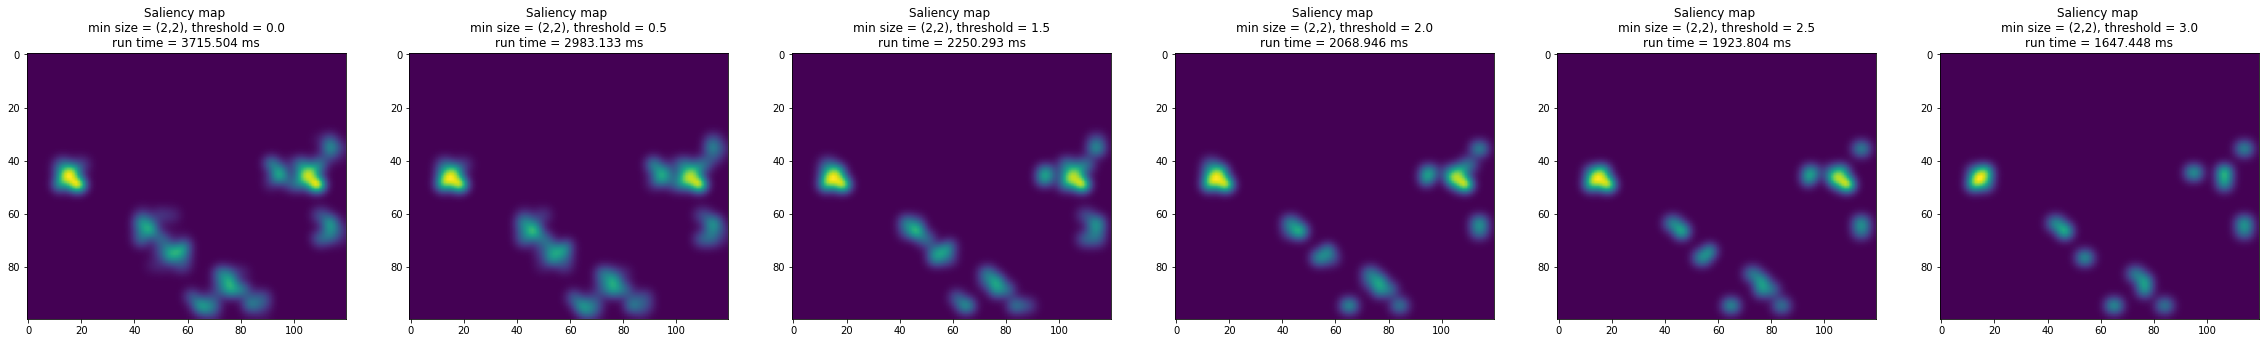

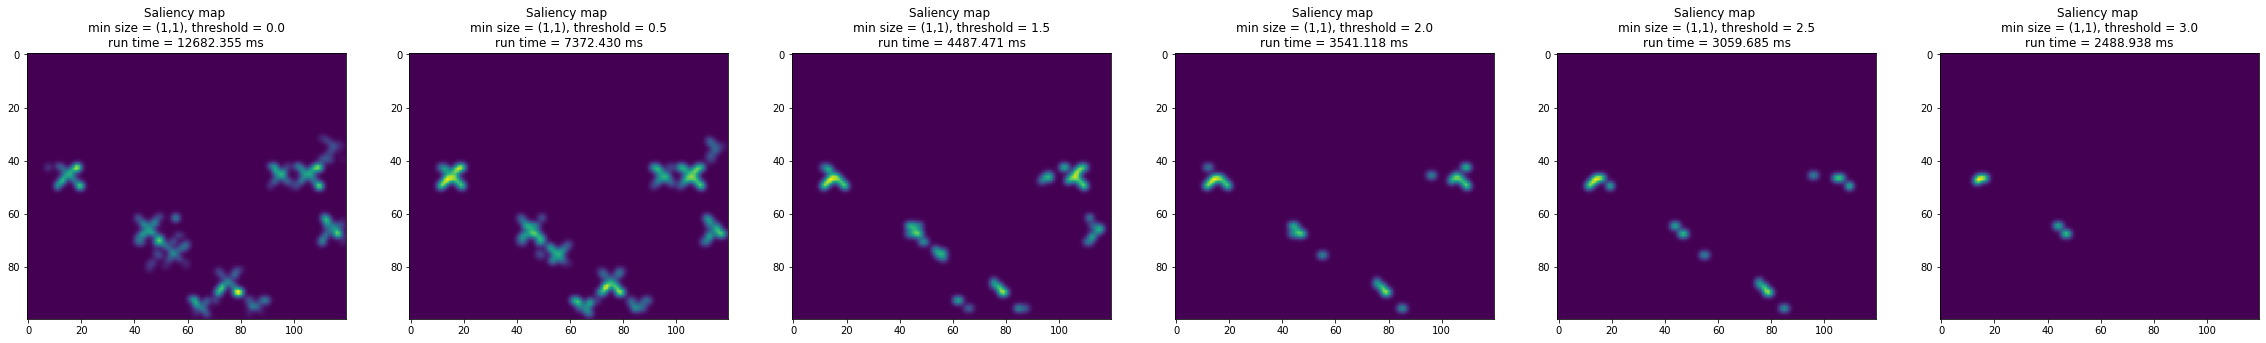

In [ ]:
sizes = np.array([[20,20], [10,10], [5, 5], [4, 4], [3, 3], [2, 2], [1, 1]])
thresholds = np.array([0., 0.5, 1.5, 2., 2.5, 3], dtype=float)

L1 = len(thresholds)
L2 = len(sizes)
X = np.zeros((L1, L2))
Y1 = np.zeros((L1, L2))
Y2 = np.zeros((L1, L2))
  
for i in np.arange(L2):
  size = sizes[i]
  minW = size[0]
  minH = size[1]
  fig = plt.figure(figsize=(40, 10))
  axes = fig.subplots(1, L1)
  for j in np.arange(L1):
    threshold = thresholds[j]
    t0 = time.time()
    print("\nSTARTED EXPLAINING IMAGE @", t0, "s")
    saliency_map, flatnodes = explainer.explain(image1, background, label = 1, threshold = threshold, minW = minW, minH = minH)
    tf = time.time()
    smooth_saliency_map = sp.ndimage.filters.gaussian_filter(saliency_map, [minW, minH], mode = 'constant')
    computed = explainer.computed
    rejected = explainer.rejected
    X[j, i] = minW
    Y1[j, i] = computed
    Y2[j, i] = rejected
    print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
    print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))
    axes[j].imshow(smooth_saliency_map)
    axes[j].set_title('Saliency map \nmin size = (%d,%d), threshold = %.1f\nrun time = %.3f ms' % (minW, minH, threshold, round((tf - t0) * 1000, 3)))


### Plot number of features computed and rejection rate as a function of minimal feature size

We define the feature rejection rate as the percentage of computed features that are considered non-relevant.

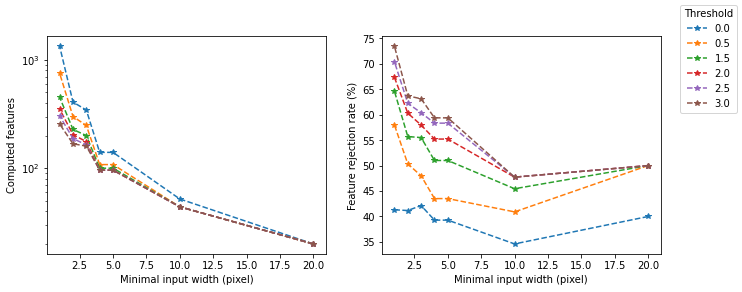

In [ ]:
fig = plt.figure(figsize=(11, 4))
ax1, ax2 = fig.subplots(1, 2)

lines = []
labels = []

for i in np.arange(L1):
  l = ax1.plot(X[i, :], Y1[i, :], '*--')[0]
  ax2.plot(X[i, :], Y2[i, :]/Y1[i, :] * 100, '*--')
  lines.append(l)
  labels.append(thresholds[i])

ax1.set_xlabel('Minimal input width (pixel)')
ax1.set_ylabel('Computed features')
ax1.set_yscale('log')
ax2.set_xlabel('Minimal input width (pixel)')
ax2.set_ylabel('Feature rejection rate (%)')
fig.legend(lines, labels, title = "Threshold")
plt.show()

## Saliency map comparison: GradientExplainer vs DeepExplainer vs KernelExplainer vs HierarchicalExplainer

Compare saliency maps obtained with various SHAP implementations

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
File ‘local_modules/utils.py’ already there; not retrieving.

Gradient Explainer:
Execution completed in 2.48 s
Deep Explainer:
Execution completed in 1.63 s
Kernel Explainer:


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



Execution completed in 1.63 s
Hierarchical Explainer:
Computed 268 features out of 12000 pixels (2.23 %) in 2.90 s -> 10.809 ms per feature
Rejected 149 features (55.60 %) @ threshold = 0.5 , minimal feature size = (2,2)
(100, 120)
Gradient Explainer:
Execution completed in 2.45 s
Deep Explainer:
Execution completed in 1.58 s
Kernel Explainer:


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



Execution completed in 1.58 s
Hierarchical Explainer:
Computed 120 features out of 12000 pixels (1.00 %) in 1.38 s -> 11.461 ms per feature
Rejected 58 features (48.33 %) @ threshold = 0.5 , minimal feature size = (2,2)
(100, 120)
Gradient Explainer:
Execution completed in 2.47 s
Deep Explainer:
Execution completed in 1.61 s
Kernel Explainer:


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



Execution completed in 1.61 s
Hierarchical Explainer:
Computed 252 features out of 12000 pixels (2.10 %) in 2.67 s -> 10.604 ms per feature
Rejected 123 features (48.81 %) @ threshold = 0.5 , minimal feature size = (2,2)
(100, 120)
Gradient Explainer:
Execution completed in 2.45 s
Deep Explainer:
Execution completed in 1.58 s
Kernel Explainer:


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



Execution completed in 1.58 s
Hierarchical Explainer:
Computed 316 features out of 12000 pixels (2.63 %) in 3.37 s -> 10.661 ms per feature
Rejected 152 features (48.10 %) @ threshold = 0.5 , minimal feature size = (2,2)
(100, 120)
Gradient Explainer:
Execution completed in 2.41 s
Deep Explainer:
Execution completed in 1.58 s
Kernel Explainer:


l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!



Execution completed in 1.58 s
Hierarchical Explainer:
Computed 252 features out of 12000 pixels (2.10 %) in 2.73 s -> 10.834 ms per feature
Rejected 144 features (57.14 %) @ threshold = 0.5 , minimal feature size = (2,2)
(100, 120)


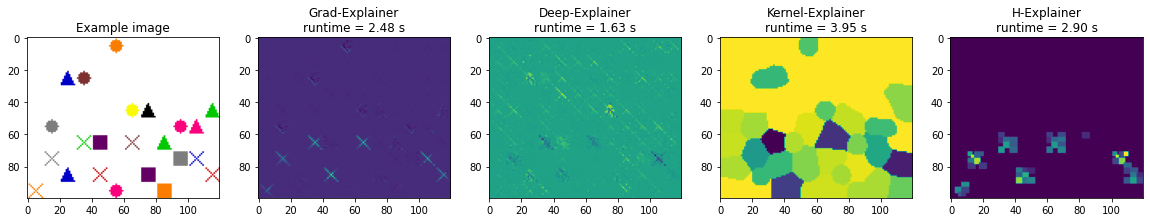

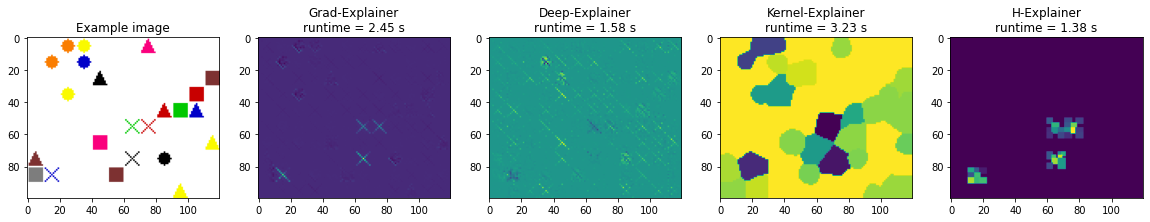

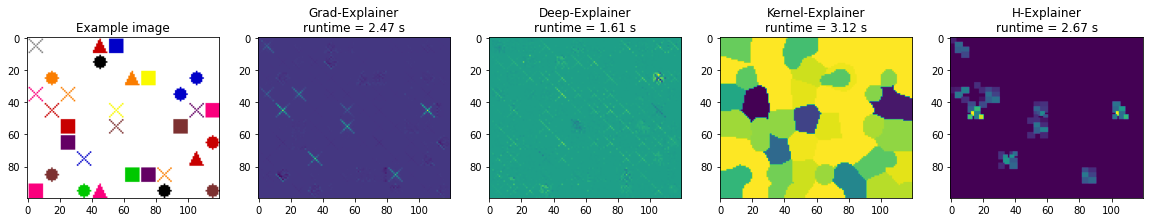

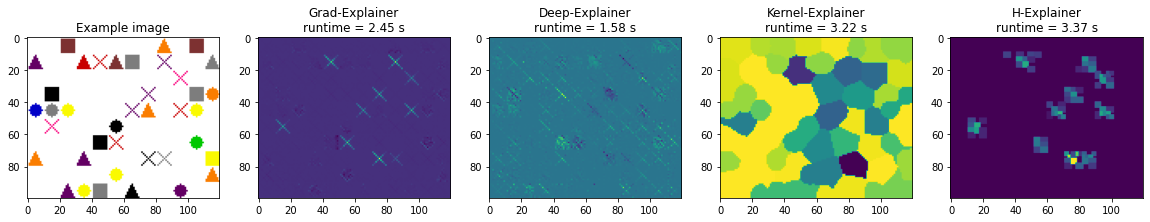

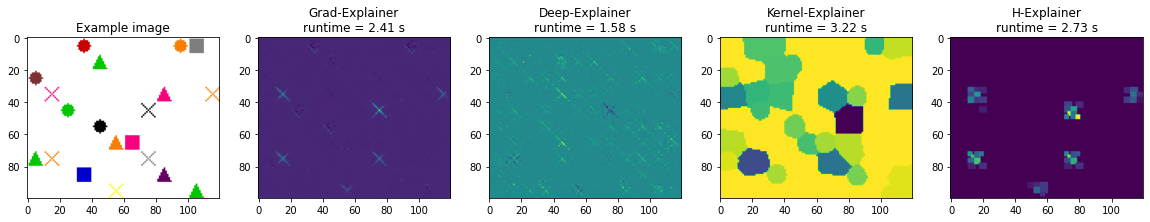

In [ ]:
#IMPORTS
from scipy.special import comb
from itertools import permutations
from functools import reduce
import time
import numpy as np
import torch 
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Normalize
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
from torch.utils.data import DataLoader
from google.colab import drive
drive.mount('/content/drive/')

#IMPORT UTILS
!wget https://raw.githubusercontent.com/JacopoTeneggi/Interpretability/master/Utils/utils.py -P local_modules -nc
import local_modules.utils as Utils

#INSTALL SHAP
!pip install shap
import shap

#LOAD PRE-TRAINED-NETWORK
model = Utils.Net()
model.load_state_dict(torch.load('drive/My Drive/Interpretability/model2.pth')) 
# model.eval() deactivates the dropout layer in the network
model.eval()

MEAN, STD = np.array([0.5, 0.5, 0.5]), np.array([0.5, 0.5, 0.5])
transf = transforms.Compose([ToTensor(), Normalize(mean=MEAN, std=STD)])

# LOAD TRAIN DATA
data = zipfile.ZipFile("/content/drive/My Drive/Interpretability/5000/data2/data.zip", 'r')
train_data_dir = "train_data_dir"
data.extractall(train_data_dir)
data.close()
train_batch_size = 64
train_data = ImageFolder(root = os.path.join(train_data_dir, 'train'), transform = transf)
dataloader = DataLoader(train_data, batch_size = train_batch_size, shuffle = True, num_workers = 0)
train_loader = iter(dataloader)
X, Y = next(train_loader)
# DEFINE MASK BACKGROUND WITH AVERAGE OF TRAINING SET
background = torch.mean(X, dim = 0)
background.detach()

def mask_image(zs, segmentation, image, background = None):
  if background is None:
    background = image.mean((0,1))
  out = np.zeros((zs.shape[0], image.shape[0], image.shape[1], image.shape[2]))
  for i in range(zs.shape[0]):
    out[i,:,:,:] = image
    for j in range(zs.shape[1]):
      if zs[i,j] == 0:
        out[i][segmentation == j,:] = background
  # SHIFT CHANNELS: form (1, 100, 120, 3) to (1, 3, 100, 120)
  out2 = np.zeros((zs.shape[0], image.shape[2], image.shape[0], image.shape[1]), dtype = 'd')
  for i in range(zs.shape[0]):
    for j in range(image.shape[2]):
      out2[i, j, :, :] = out[i, :, :, j]
  out2 = torch.from_numpy(out2)
  out2 = out2.type(torch.FloatTensor)
  return out2.detach()

def fill_segmentation(values, segmentation):
  out = np.zeros(segmentation.shape)
  for i in range(len(values)):
    out[segmentation == i] = values[i]
  return out

def f(z):
  return model(mask_image(z, segments_slic, img_orig, background = None)).detach().numpy()

# LOAD EXAMPLE IMAGES FOLDER
ImF = ImageFolder(root = "/content/drive/My Drive/H-Shap", transform = transf)
example_batch_size = 5
exloader = DataLoader(ImF, batch_size = example_batch_size, shuffle = False, num_workers = 0)
exIter = iter(exloader)
images, labels = next(exIter)
L = len(images) # number of examples
M = 4 # number of explainers

saliency_map_store = np.zeros((M, L, 100, 120))

for i in np.arange(L):
  image = images[i]

  # DEFINE INPUT
  input = image.view(-1, 3, 100, 120)
  input = input.detach()

  # GRADIENT EXPLAINER
  print('Gradient Explainer:')
  gradexp = shap.GradientExplainer(model, X)
  nsamples = 200
  t0 = time.time()
  gradexp_shapley_values, gradexp_indexes = gradexp.shap_values(input, ranked_outputs=2, nsamples = nsamples)
  tf = time.time()
  gradexp_runtime = round(tf - t0, 2)
  gradexp_saliency = np.sum(gradexp_shapley_values[0][0], 0)
  saliency_map_store[0, i, :, :] = gradexp_saliency
  print('Execution completed in %.2f s' % (gradexp_runtime))

  # DEEP EXPLAINER
  print('Deep Explainer:')
  deepexp = shap.DeepExplainer(model, X)
  t0 = time.time()
  deepexp_shapley_values, deepexp_indexes = deepexp.shap_values(input)
  tf = time.time()
  deepexp_runtime = round(tf - t0, 2)
  deepexp_saliency = deepexp_shapley_values[0][0]
  saliency_map_store[1, i, :, :] = deepexp_saliency
  print('Execution completed in %.2f s' % (deepexp_runtime))

  # KERNEL EXPLAINER
  print('Kernel Explainer:')
  from skimage.segmentation import slic
  from keras.preprocessing import image as keras_img_tools

  file = '/content/drive/My Drive/H-Shap/Examples/ex%d.png' % (i+1)
  img = keras_img_tools.load_img(file)
  img_orig = keras_img_tools.img_to_array(img)
  segments_slic = slic(img, n_segments = 50, compactness = 30, sigma = 3)

  kernelexp = shap.KernelExplainer(f, np.zeros((1, 50)))
  t0 = time.time()
  kernelexp_shapley_values = kernelexp.shap_values(np.ones((1, 50)), nsamples = 1000)
  tf = time.time()
  kernelexp_runtime = round(tf - t0, 2)
  print('Execution completed in %.2f s' % (deepexp_runtime))

  kernelexp_saliency = fill_segmentation(kernelexp_shapley_values[0][0], segments_slic)
  saliency_map_store[2, i, :, :] = kernelexp_saliency

  # H-SHAP EXPLAINER
  print('Hierarchical Explainer:')
  hexp = HierarchicalSHAPExplainer(model, background, 4)
  threshold = .5
  label = 1
  minW = 2
  minH = 2
  t0 = time.time()
  hexp_saliency, flatnodes = hexp.explain(image, background, label = label, threshold = threshold, minW = minW, minH = minH)
  tf = time.time()
  # smooth saliency map
  sigma = [minW, minH]
  # hexp_saliency = sp.ndimage.filters.gaussian_filter(hexp_saliency, sigma, mode='constant')
  hexp_runtime = round(tf - t0, 2)
  saliency_map_store[3, i, :, :] = hexp_saliency
  computed = hexp.computed
  rejected = hexp.rejected
  print('Computed %d features out of %d pixels (%.2f %%) in %.2f s -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round(tf - t0, 2), round(((tf-t0)*1000)/computed, 3)))
  print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))

  fig = plt.figure(figsize=(20, 4))
  ax1, ax2, ax3, ax4, ax5 = fig.subplots(1, 5)
  # SHOW EXAMPLE IMAGE
  ax1.imshow(Utils.input2image(image, MEAN, STD))
  ax1.set_title('Example image')
  # SHOW GRADIENT EXPLAINER SALIENCY MAP
  ax2.imshow(gradexp_saliency)
  ax2.set_title('Grad-Explainer\nruntime = %.2f s' % gradexp_runtime)
  # SHOW DEEP EXPLAINER SALIENCY MAP
  ax3.imshow(deepexp_saliency)
  ax3.set_title('Deep-Explainer\nruntime = %.2f s' % deepexp_runtime)
  # SHOW KERNEL EXPLAINER SALIENCY MAP
  ax4.imshow(kernelexp_saliency)
  ax4.set_title('Kernel-Explainer\nruntime = %.2f s' % kernelexp_runtime)
  # SHOW HIERARCHICAL EXPLAINER SALIENCY MAP
  ax5.imshow(hexp_saliency)
  print(hexp_saliency.shape)
  ax5.set_title('H-Explainer\nruntime = %.2f s' % hexp_runtime)

## Log-odd ratio drop

Plot logit drop as salient regions are perturbed

overflow encountered in exp
invalid value encountered in true_divide
overflow encountered in exp
invalid value encountered in true_divide
overflow encountered in exp
invalid value encountered in true_divide
overflow encountered in exp
invalid value encountered in true_divide


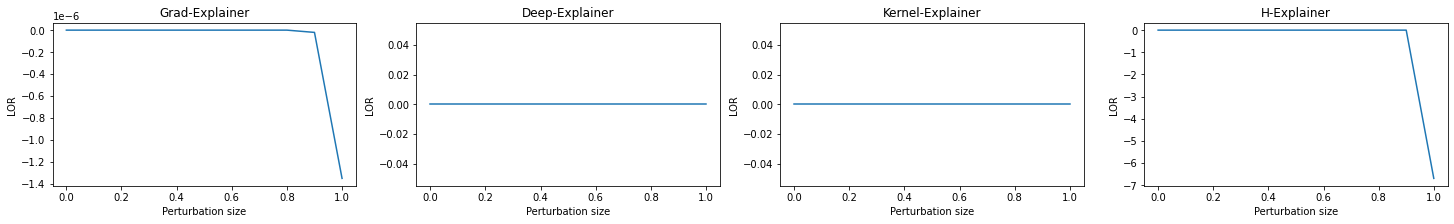

In [ ]:
expmapper = {
  0: {'name': 'Grad-Explainer', 'exp': gradexp },
  1: {'name': 'Deep-Explainer', 'exp': deepexp},
  2: {'name': 'Kernel-Explainer', 'exp': kernelexp},
  3: {'name': 'H-Explainer', 'exp': hexp}
}
saliency_maps = [gradexp_saliency, deepexp_saliency, kernelexp_saliency, hexp_saliency]
resolution = 1e-1
perturbation_sizes = np.arange(0, 1 + resolution, resolution)
activation_threshold = 0
EXIMG_L = len(images) # number of example images
EXP_L = len(expmapper) # number of explainers
LOR_L = len(perturbation_sizes) # number of masking samples
LOR = np.zeros((EXP_L, EXIMG_L, LOR_L))

fig = plt.figure(figsize=(25, 3))
LOR_axes = fig.subplots(1, len(expmapper))

# for each explainer
for i in np.arange(EXP_L): # for each example image
  for eximg_id in np.arange(EXIMG_L):
    exp_name = expmapper[i]['name']
    exp = expmapper[i]['exp']
    saliency_map = saliency_map_store[i, eximg_id, :, :]
    # fig = plt.figure()
    # ax = fig.subplots()
    # ax.imshow(saliency_map)
    salient_points = np.where(saliency_map > activation_threshold)
    salient_rows = salient_points[0]
    salient_columns = salient_points[1]
    L = len(salient_rows)
    # print(L)
    ids = np.arange(L)
    # LOR = np.zeros(LOR_L)
    for k in np.arange(LOR_L):
      perturbation_size = perturbation_sizes[k]
      perturbation_L = int(perturbation_size * L)
      perturbed_ids = np.random.choice(ids, replace = False, size = perturbation_L)
      # print(perturbation_size, perturbation_L, len(perturbed_ids), len(np.unique(perturbed_ids)))
      perturbed_img = images[eximg_id].clone()
      perturbed_rows = salient_rows[perturbed_ids]
      perturbed_columns = salient_columns[perturbed_ids]
      for j in np.arange(perturbation_L):
        row = perturbed_rows[j]
        column = perturbed_columns[j]
        perturbed_img[:, row, column] = background[:, row, column]
      # fig = plt.figure()
      # ax = fig.subplots()
      # ax.imshow(Utils.input2image(perturbed_img, MEAN, STD))
      perturbed_input = perturbed_img.view(-1, 3, 100, 120)
      prediction = model(perturbed_input).detach().numpy()[0]
      # print(prediction)
      logits = np.exp(prediction)/np.sum(np.exp(prediction))
      # print(logits)
      if np.isnan(logits[1]):
        logits[1] = 1
      LOR[i, eximg_id, k] = np.log10(logits[1])
  # print(LOR[i, :, :])
  LOR_axes[i].plot(perturbation_sizes, np.mean(LOR[i, :, :], axis = 0), label = exp_name)
  LOR_axes[i].set_xlabel('Perturbation size')
  LOR_axes[i].set_ylabel('LOR')
  LOR_axes[i].set_title(exp_name)
  # print(exp_name, salient_points)

## Evaluate H-Explainer sensitivity and specificity

Evaluate H-Explainer sensitivity and specificity as a function of threshold and minimal feature size

In [ ]:
# LOAD EXAMPLE IMAGES FOLDER
ImF = ImageFolder(root = "/content/drive/My Drive/H-Shap", transform = transf)
example_batch_size = 5
exloader = DataLoader(ImF, batch_size = example_batch_size, shuffle = False, num_workers = 0)
exIter = iter(exloader)
images, labels = next(exIter)
label = 1
EXIMG_L = len(images)

# INITIALIZE H-EXPLAINER
hexp = HierarchicalSHAPExplainer(model, background, 4)
threshold = .5
label = 1
minW = 2
minH = 2
t0 = time.time()
hexp_saliency, flatnodes = hexp.explain(image, background, label = label, threshold = threshold, minW = minW, minH = minH)

# DEFINE H-EXPLAINER PARAMETERS
upperScoreLimit = 3
hexp_thresholds = np.arange(0, upperScoreLimit, .5)
hexp_sizes = np.array([40, 20, 10, 5, 4, 2, 1])
HEXP_THRESHOLD_L = len(hexp_thresholds)
HEXP_SIZE_L = len(hexp_sizes)

# DEFINE ACTIVATION THRESHOLDS
activationThresholds = np.arange(0, upperScoreLimit, upperScoreLimit / 100)
THRESH_L = len(activationThresholds)

# DEFINE STORAGE
stor = np.zeros((EXIMG_L, HEXP_THRESHOLD_L, HEXP_SIZE_L, THRESH_L, 2))

# FOR EACH EXAMPLE IMAGE
for eximg_id in np.arange(EXIMG_L):

  image = images[eximg_id]
  # LOAD TRUTH MAP
  truthMap = np.genfromtxt('/content/drive/My Drive/H-Shap/Examples/truth_%d.csv' % (eximg_id + 1), delimiter=',')

  # FOR EACH THRESHOLD
  for hexp_threshold_id in np.arange(HEXP_THRESHOLD_L):

    hexp_threshold = hexp_thresholds[hexp_threshold_id]

    # FOR EACH MINIMAL SIZE
    for hexp_size_id in np.arange(HEXP_SIZE_L):

      minSize = hexp_sizes[hexp_size_id]

      # EXPLAIN IMAGE
      print('Explaining image %d, threshold = %.2f, min-size = %d' % (eximg_id, hexp_threshold, minSize))
      hexp_saliency, flatnodes = hexp.explain(image, background, label = label, threshold = hexp_threshold, minW = minSize, minH = minSize)
      
      # FOR EACH ACTIVATION THRESHOLD
      for thresh_id in np.arange(THRESH_L):

        activationThreshold = activationThresholds[thresh_id]

        hexp_map = hexp_saliency.copy()
        # REMOVE PIXELS BELOW ACTIVATION THRESHOLD
        hexp_map[np.where(hexp_saliency < activationThreshold)] = 0
        # HIGHLIGHT POSITIVELY MARKED PIXELS
        hexp_map[np.where(hexp_saliency > activationThreshold)] = 1 

        # EVALUATE TRUE POSITIVE RATE (TPR)
        totalPositives = np.sum(truthMap)
        hexp_TPR = np.sum(hexp_map[np.where(truthMap == 1)]) / totalPositives

        # EVALUATE FALSE POSITIVE RATE (FPR)
        totalNegatives = 100*120 - totalPositives
        hexp_FPR = np.sum(hexp_map[np.where(truthMap == 0)]) / totalNegatives

        # SAVE VALUES
        stor[eximg_id, hexp_threshold_id, hexp_size_id, thresh_id, 0] = hexp_TPR 
        stor[eximg_id, hexp_threshold_id, hexp_size_id, thresh_id, 1] = hexp_FPR
# SHOW ACTIVATION MAPS WITH SENSITIVITY AND FALSE ALARM RATES
# fig = plt.figure(figsize=(10, 10))
# ax1, ax2 = fig.subplots(1, 2)
# ax1.imshow(gradientMap)
# ax1.set_title('Grad-explainer activation map\nActivation threshold = %.2f\nTPR = %.2f%% -- FPR = %.2f%%' % (activationThreshold, gradientSe * 100, gradientFa * 100))
# ax2.imshow(hierarchicalMap)
# ax2.set_title('H-explainer activation map (threshold = %.2f)\nActivation threshold = %.2f\nTPR = %.2f%% -- FPR = %.2f%%' % (threshold, activationThreshold, hierarchicalSe * 100, hierarchicalFa * 100))

Explaining image 0, threshold = 0.00, min-size = 40
Explaining image 0, threshold = 0.00, min-size = 20
Explaining image 0, threshold = 0.00, min-size = 10
Explaining image 0, threshold = 0.00, min-size = 5
Explaining image 0, threshold = 0.00, min-size = 4
Explaining image 0, threshold = 0.00, min-size = 2
Explaining image 0, threshold = 0.00, min-size = 1
Explaining image 0, threshold = 0.50, min-size = 40
Explaining image 0, threshold = 0.50, min-size = 20
Explaining image 0, threshold = 0.50, min-size = 10
Explaining image 0, threshold = 0.50, min-size = 5
Explaining image 0, threshold = 0.50, min-size = 4
Explaining image 0, threshold = 0.50, min-size = 2
Explaining image 0, threshold = 0.50, min-size = 1
Explaining image 0, threshold = 1.00, min-size = 40
Explaining image 0, threshold = 1.00, min-size = 20
Explaining image 0, threshold = 1.00, min-size = 10
Explaining image 0, threshold = 1.00, min-size = 5
Explaining image 0, threshold = 1.00, min-size = 4
Explaining image 0, th

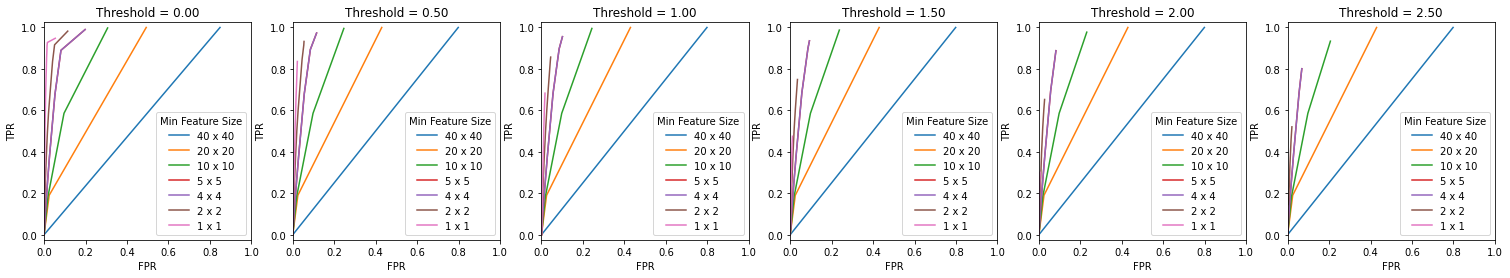

In [ ]:
fig = plt.figure(figsize=(26, 4))
axes = fig.subplots(1, HEXP_THRESHOLD_L)

for hexp_threshold_id in np.arange(HEXP_THRESHOLD_L):

  ax = axes[hexp_threshold_id]
  ax.axis('equal')
  ax.set_xlim(0, 1)
  ax.set_ylim(0, 1)
  ax.set_xlabel('FPR')
  ax.set_ylabel('TPR')
  ax.set_title('Threshold = %.2f' % hexp_thresholds[hexp_threshold_id])

  for hexp_size_id in np.arange(HEXP_SIZE_L):

    # SELECT
    TPR = stor[:, hexp_threshold_id, hexp_size_id, :, 0]
    FPR = stor[:, hexp_threshold_id, hexp_size_id, :, 1]
    # AVERAGE
    mean_TPR = np.mean(TPR, axis = 0) 
    mean_FPR = np.mean(FPR, axis = 0)

    ax.plot(mean_FPR, mean_TPR, label = '%d x %d' % (hexp_sizes[hexp_size_id], hexp_sizes[hexp_size_id]))
  
  ax.legend(title = 'Min Feature Size')

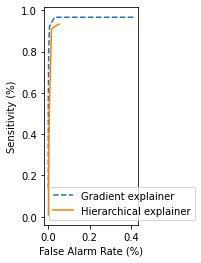

In [ ]:




gradientMap = np.sum(shapley_values[0][0], 0)
hierarchicalMap = saliency_map.copy()

upperScoreLimit = np.minimum(np.amax(gradientMap), np.amax(hierarchicalMap))
activationThresholds = np.arange(0, upperScoreLimit, upperScoreLimit / 100)
L = len(activationThresholds)
gradientSes = np.zeros(L)
gradientFas = np.zeros(L)
hierarchicalSes = np.zeros(L)
hierarchicalFas = np.zeros(L)

for i in np.arange(L):
  activationThreshold = activationThresholds[i]

  # INITIALIZE COMPLETE SALIENCY MAPS
  gradientMap = np.sum(shapley_values[0][0], 0)
  hierarchicalMap = saliency_map.copy()

  # REMOVE PIXELS BELOW ACTIVATION THRESHOLD
  gradientMap[np.where(gradientMap < activationThreshold)] = 0
  hierarchicalMap[np.where(hierarchicalMap < activationThreshold)] = 0
  # HIGHLIGHT POSITIVELY MARKED PIXELS
  gradientMap[np.where(gradientMap > activationThreshold)] = 1
  hierarchicalMap[np.where(hierarchicalMap > activationThreshold)] = 1 

  # EVALUATE SENSITIVITY
  totalPositives = np.sum(truthMap)
  gradientSe = np.sum(gradientMap[np.where(truthMap == 1)]) / totalPositives
  hierarchicalSe = np.sum(hierarchicalMap[np.where(truthMap == 1)]) / totalPositives

  # EVALUATE FALSE ALARM
  totalNegatives = 100*120 - totalPositives
  gradientFa = np.sum(gradientMap[np.where(truthMap == 0)]) / totalNegatives
  hierarchicalFa = np.sum(hierarchicalMap[np.where(truthMap == 0)]) / totalNegatives

  # SAVE VALUES
  gradientSes[i] = gradientSe
  gradientFas[i] = gradientFa
  hierarchicalSes[i] = hierarchicalSe
  hierarchicalFas[i] = hierarchicalFa

fig = plt.figure(figsize=(5, 3))
ax1= fig.subplots()
ax1.plot(gradientFas, gradientSes, '--', label = 'Gradient explainer')
ax1.plot(hierarchicalFas, hierarchicalSes, '-', label = 'Hierarchical explainer')
ax1.set_xlabel('False Alarm Rate (%)')
ax1.set_ylabel('Sensitivity (%)')
ax1.legend()
ax1.set_aspect('equal', 'box')

In [ ]:
# EVALUATE ORIGINAL MODEL output
output = model(input).detach().numpy()
exactPrediction = output[0][label]
print('\nEXACT PREDICTION = %.3f' % (exactPrediction))

sizes = np.array([[50, 50], [20,20], [10,10], [5, 5], [4, 4], [3, 3], [2, 2], [1, 1]])
L = len(sizes)

# INITIALIZE SHAP GRADIENT EXPLAINER
gradexp = shap.GradientExplainer(model, X)
nsamples = 200
nruns = 10
gradPredictions = np.zeros(nruns)

for i in np.arange(nruns):
  t0 = time.time()
  shapley_values, indexes = gradexp.shap_values(input, ranked_outputs=2, nsamples=nsamples)
  tf = time.time()
  gradPrediction = np.sum(shapley_values[0])
  gradPredictions[i] = gradPrediction
  print('\nGradient Explainer:\nExecution completed in %.3f ms\nPREDICTION = %.3f' % ((tf - t0)*1e3, gradPrediction))
  #shapley_values = [np.swapaxes(np.swapaxes(s, 2, 3), 1, -1) for s in shapley_values]
  #image = image[np.newaxis, :]
  #shap.image_plot(shapley_values, image, indexes.numpy(), show=False)

# INITIALIZE SHAP DEEP EXPLAINER
deepexp = shap.DeepExplainer(model, X)

# HIERARCHICAL SHAP
# EXPLAIN IMAGE 1 (with correct label)
hierarchicalPredictions = np.zeros(L)

for i in np.arange(L):
  t0 = time.time()
  print("\nHierarchical Explainer:\nSTARTED EXPLAINING IMAGE 1 @", t0, "s")
  threshold = np.NINF
  size = sizes[i]
  minW = size[0]
  minH = size[1]
  saliency_map, flatnodes = explainer.explain(image1, background, label = 1, threshold = threshold, minW = minW, minH = minH)
  tf = time.time()
  hierarchicalPrediction = np.sum(saliency_map)
  hierarchicalPredictions[i] = hierarchicalPrediction
  computed = explainer.computed
  rejected = explainer.rejected
  print('PREDICTION = %.3f' % hierarchicalPrediction)
  print('Computed %d features out of %d pixels (%.2f %%) in %.3f ms -> %.3f ms per feature' % (computed, 100*120, round(computed/120, 2), round((tf -t0) * 1000, 3), round(((tf-t0)*1000)/computed, 3)))
  print('Rejected %d features (%.2f %%) @ threshold = %.1f , minimal feature size = (%d,%d)' % (rejected, round(rejected/computed*100, 2), threshold, minW, minH))


EXACT PREDICTION = 73.542

Gradient Explainer:
Execution completed in 2280.462 ms
PREDICTION = 57.860

Gradient Explainer:
Execution completed in 2285.942 ms
PREDICTION = 63.544

Gradient Explainer:
Execution completed in 2360.817 ms
PREDICTION = 64.182

Gradient Explainer:
Execution completed in 2290.975 ms
PREDICTION = 63.674

Gradient Explainer:
Execution completed in 2436.818 ms
PREDICTION = 65.893

Gradient Explainer:
Execution completed in 2328.454 ms
PREDICTION = 64.121

Gradient Explainer:
Execution completed in 2450.155 ms
PREDICTION = 65.283

Gradient Explainer:
Execution completed in 2312.509 ms
PREDICTION = 66.076

Gradient Explainer:
Execution completed in 2361.179 ms
PREDICTION = 67.133

Gradient Explainer:
Execution completed in 2403.937 ms
PREDICTION = 63.577

Hierarchical Explainer:
STARTED EXPLAINING IMAGE 1 @ 1597256381.093442 s
PREDICTION = 88.773
Computed 4 features out of 12000 pixels (0.03 %) in 43.890 ms -> 10.972 ms per feature
Rejected 0 features (0.00 %) @ t

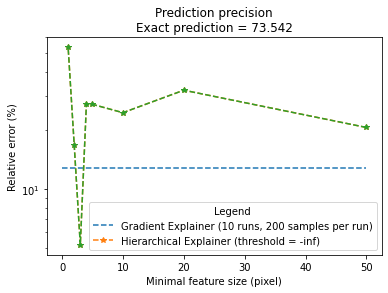

In [ ]:
# COMPARE RESULTS
gradientError = np.absolute((exactPrediction - gradPredictions.mean()) / exactPrediction) * 100
hierarchicalError = np.absolute((exactPrediction - hierarchicalPredictions) / exactPrediction) * 100



fig = plt.figure()
ax = fig.subplots()
gradientl = ax.plot([0, sizes[0][0]], [gradientError, gradientError], '--')[0]
hierarchicall = ax.plot(sizes, hierarchicalError, '*--')[0]
ax.set_yscale('log')
ax.set_xlabel('Minimal feature size (pixel)')
ax.set_ylabel('Relative error (%)')
ax.set_title('Prediction precision\nExact prediction = %.3f' % exactPrediction)
lines = [gradientl, hierarchicall]
labels = ['Gradient Explainer (%d runs, %d samples per run)' % (nruns, nsamples), 'Hierarchical Explainer (threshold = %.3f)' % np.NINF]
ax.legend(lines, labels, title = 'Legend')